# 3. Exercise


Yash Waware

Christoforos Eseroglou(12331470)  

## 3.1 Cylindrical coordinates for the rotational symmetric plate capacitator

In [1]:
# Imports
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.csg import *
import numpy as np
import matplotlib.pyplot as plt

### 3.1.1. 3D Condensator in Cartesian Coordinates

In [4]:
half_domain = WorkPlane().MoveTo(0, -5).Rectangle(5, 10).Face()
electrode1 = WorkPlane().MoveTo(0, 0.3).Rectangle(0.4, 0.1).Face()
electrode2 = WorkPlane().MoveTo(0, -0.4).Rectangle(0.4, 0.1).Face()

half_domain.edges[0].name = "bottom"
half_domain.edges[1].name = "mantle"
half_domain.edges[2].name = "top"
half_domain.edges[3].name = "center"


# Draw(half_domain - electrode1 - electrode2)
electrode1.edges.name = "electrode1"
electrode2.edges.name = "electrode2"

electrode1.edges.maxh = 0.05
electrode2.edges.maxh = 0.05

total = half_domain - electrode1 - electrode2

# Rotates the whole face into 3d
cylinder = total.Revolve(Axis((0,0,0), Y), 360)
geo = OCCGeometry(cylinder, dim=3)

mesh = Mesh(geo.GenerateMesh(maxh=0.8))

Draw(mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

#### Bilinear and Linear Form

In [5]:
EPSILON = 8.854 * 10**(-12)

fes = H1(mesh, order=2, dirichlet="electrode1|electrode2|mantle")
u, v = fes.TnT()


cf = mesh.BoundaryCF({
    "electrode1": -1.0,
    "electrode2": 1.0,
}, default=0)

gfu = GridFunction(fes)
gfu.Set(cf, definedon=mesh.Boundaries(".*"))


a = BilinearForm(EPSILON*grad(u)*grad(v)*dx).Assemble()
f = LinearForm(fes).Assemble()

#### Solution step

In [6]:
inv = a.mat.Inverse(fes.FreeDofs())
res = f.vec - a.mat * gfu.vec
gfu.vec.data += inv * res

# Draw(gfu, clipping={"y":0, "z":-0.01, "dist":0.0, "function" : True })

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

#### Computation of the Electric Energy

In [7]:
integrand = (0.5 * EPSILON * Norm(grad(gfu)) ** 2 ) 

elec_energy_cylinder_cart = Integrate(integrand, mesh)

print("Electric energy as calculated in cartesian coords: ", elec_energy_cylinder_cart)

Electric energy as calculated in cartesian coords:  5.2525733868204e-11


### 3.1.2. Using cylindrical coordinates

#### 3.1.2.1. Derivation of the weak formulation in cylindrical coordinates

We can use cylindrical coordinates and the symmetry of the solution

$$ u^{3D}(r, \phi, z) = u(r, z)$$

to transform the variational formulation in cylindrical coordinates.

The symmetry means, that the electric potential $u$ inside the 3D cylindrical capacitator does only depend on the position in z-diretion and the distance $r$ to the rotation axis of the cylinder.

Thus, we can solve the problem in a 2D plane by using the transformation theorem for the gradient and for the integration to obtain the electric potential and electric energy in cylindrical coordinates.

We start by defining the basis vectors in cylindrical coordinates $e_r, e_{\phi}, e_z$ via the cartesian basis vectors $e_1, e_2, e_3$

- $e_r = cos(\phi)e_1 + sin(\phi)e_2$
- $e_{\phi} = -sin(\phi)e_1 + cos(\phi)e_2$
- $e_z = e_3$

Next we define the differential operator in cylindrical coordinates:

$$\nabla_{r, \phi, z} = \frac{\partial}{\partial r}e_r + \frac{1}{r} \frac{\partial}{\partial \phi}e_{\phi} + \frac{\partial}{\partial z}e_z$$

The weak formulation of the poisson problem for the cylindrical capacitator

$$ \epsilon_0  \int_{\Omega} \nabla u \nabla v dx = 
\epsilon_0  \int_{z_0}^{z_1} \int_{y_0}^{y_1} \int_{x_0}^{x_1} \nabla u(x, y, z) \nabla v(x, y, z)  \space dx dy dz =0 $$

can be rewritten in cylindrical coordinates using the indepency of $\phi$ ($\frac{1}{r}\frac{\partial u}{\partial \phi}e_{\phi}=0$)

$$\nabla u(r, z) = \frac{\partial u}{\partial r}e_r +  \frac{\partial u}{\partial z}e_z$$

$$\nabla v(r, z) = \frac{\partial v}{\partial r}e_r +  \frac{\partial v}{\partial z}e_z$$

and the transformation theorem for integrals:

$$
\int_{\phi(u)} f(v) dv = \int_{u} f(\phi(u)) \space |det D \phi(u)| \space du \quad with \quad |det D \phi(u)| = r
$$

as

$$
\epsilon_0 \int_{\phi_0}^{\phi_1} \int_{z_0}^{z_1} \int_{r_0}^{r_1}
( \frac{\partial u}{\partial r}e_r +  \frac{\partial u}{\partial z}e_z) \space (\frac{\partial v}{\partial r}e_r +  \frac{\partial v}{\partial z}e_z)
\space r \space dr dz d\phi = 0
$$

#### 3.1.2.2. Computation of the solution in 2D

For the computation in 2D we use

- $e_r = (1, 0, 0)^T$
- $e_z = (0, 1, 0)^T$ since the 2D domain lays in the xy-plane, thus y-direction corresponds to the z-direction of the cylindrical coordinates
- $r = x$ for the determinant of the jacobian since the x coordinate in 2D corresponds to the radius in the cylindrical coordinates

In [9]:
geo = OCCGeometry(total, dim=2)
mesh = Mesh(geo.GenerateMesh(maxh=0.5))

Draw(mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [11]:
# Cylindrical basis vectors
EPSILON = 8.854 * 10**(-12)

fes = H1(mesh, order=3, dirichlet="electrode1|electrode2|mantle")
u_cyl, v_cyl = fes.TnT()


cf = mesh.BoundaryCF({
    "electrode1": -1.0,
    "electrode2": 1.0,
}, default=0)

gfu = GridFunction(fes)
gfu.Set(cf, definedon=mesh.Boundaries("electrode1|electrode2|mantle"))

#Draw(gfu)

In [12]:
# Cylindrical basis coordinates
e_r = CoefficientFunction((1, 0, 0)) # = x-direction
e_z = CoefficientFunction((0, 1, 0 )) # = y-direction
r = x

# Gradients in cylindrical basis
cf_grad_u = CoefficientFunction((grad(u_cyl)[0]*e_r + grad(u_cyl)[1]*e_z))
cf_grad_v = CoefficientFunction((grad(v_cyl)[0]*e_r + grad(v_cyl)[1]*e_z))

a = BilinearForm(EPSILON * InnerProduct(cf_grad_u, cf_grad_v) * r * dx).Assemble()
#a = BilinearForm(EPSILON*grad(u_cyl)*grad(v_cyl)*dx).Assemble()
f = LinearForm(fes).Assemble()

inv = a.mat.Inverse(fes.FreeDofs())
residuum = f.vec - a.mat * gfu.vec
gfu.vec.data += inv * residuum

Draw(gfu)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

### 3.1.3. Calculate the energy in cylindrical coordinates

The volume integral for the electrical energy in cylindrical coordinates using a 2D domain is obtained by multiplying the 2D integrand with $r$ and the surface integral with $2\pi$.

In [14]:
integrand = 0.5 * EPSILON * Norm(grad(gfu)) ** 2 

# r for integration transformation and 2*pi for rotation
elec_energy_cylinder_cyl = Integrate(integrand * r, mesh) * 2 * pi 

print("Cylindrical domain electric energy: ", elec_energy_cylinder_cyl, "J")

error = abs(elec_energy_cylinder_cart - elec_energy_cylinder_cyl)

print("Error: ", error, "J")
print('rel error: ',error/elec_energy_cylinder_cart )

Cylindrical domain electric energy:  5.233029252456841e-11 J
Error:  1.9544134363559178e-13 J
rel error:  0.003720868405684485


**Relation between $E_{cart}$ and $E_{cyl}$:**

The electric energy calculated in the 2D domain with cylindrical coordinates is up to floating point presicion ($error = 4.8 \cdot 10^{-14} \space J$) similar to the 3D result in cartesian coordinates. Thus, by exploiting the independency of the solution on the angular $\phi$, the 3D problem can be easily transformed into a 2D problem and is solved with less computational effort.

### 3.1.4. Boundary Conditions for the 2D Problems along the symmetry axis

The solution $u$ is rotation-axis symmetric to the geometrical rotation axis. Thus, similar to the quarter domain in exercise 2, the rotation axis requires homogeneous Neumann boundary condition $\frac{\partial u}{\partial n}=0$. The electric potential on this edge is non-zero and depends on the distance to the electrodes. There is also no flux in normal direction to this edge.

This boundary condition is natural and it is therefore not meaningful to set boundary conditions for the 2D problem along the axis.

**Does there exist a trace operator? Compute the norm of the trace operator on a sequence of meshes.**

In [26]:
def SetupTraceProblem(p):
    fes = H1(mesh, order=p)
    u, v = fes.TnT()
    H1Norm = BilinearForm(u*v*dx+grad(u)*grad(v)*dx ).Assemble().mat
    L2GammaNorm = BilinearForm(u*v*ds("rotation_axis"), check_unused = False).Assemble().mat
    pre = Projector(fes.FreeDofs(), range=True)
    return L2GammaNorm, H1Norm, pre, fes

[[1, 0.6218908187554193], [2, 0.6420204690584417], [3, 0.6425076111556705], [4, 0.6425980342648488], [5, 0.6426359261790292], [6, 0.6426542509720611], [7, 0.6426367822445501], [8, 0.642658643433112], [9, 0.6426615442730121]]


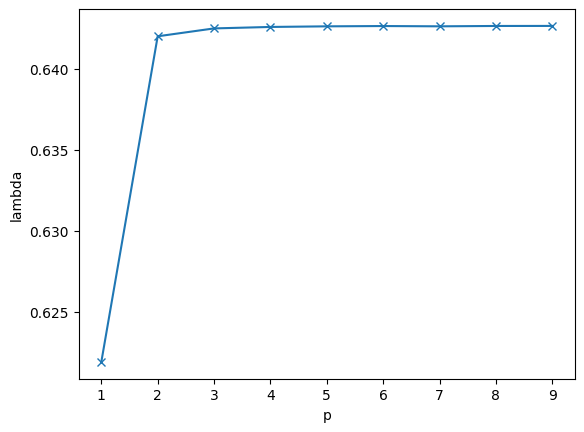

In [28]:
lams = []
for p in range(1,10):
    L2GammaNorm, H1Norm, pre, fes = SetupTraceProblem(p)
    evals,evecs = solvers.LOBPCG(H1Norm, L2GammaNorm, pre=pre, num=5, maxit=200, printrates=False)
    lams.append([p,1/evals[-1]])

print(lams)
plt.xlabel("p")
plt.ylabel("lambda")
plt.plot(*zip(*lams), '-x');

We can observe that the maximal eigenvalue converges very fast to $\lambda_{max} \approx 0.6427$.

Thus, there is hope that the norm of the trace operator $\|tr\|$ is also bounded on the Sobolev space $V$.

### 3.1.5. Define a norm such that the bilinear form is bounded and coercive

Try $L_2$ norm:

## 3.2. Friedrichs' inequality

### 3.2.1. on the segment $(a, b)$

Prove Friedrichs' inequality on the interval $I = (a,b)$ with elementary tools. Show that there exists a constant $c_F$ such that

$$
\| u \|_{L_2(I)} \leq c_F \, \| u^\prime \|_{L_2(I)} \qquad \forall \, u \in C^1(\overline{I}), \, u(a) = 0
$$

how does your constant $c_F$ depend on $a$ and $b$ ?

The $L_2$ norm on the 1D domain $\Omega = (a, b)$ is defined as

$$
\|u\|_{L_2} = \left ( \int_a^b (u(x))^2 \right)^{1/2}
$$

$$
\|u\prime\|_{L_2} = \left ( \int_a^b (u^\prime(x))^2 \right)^{1/2}
$$

We know that $u(a) = 0$, thus we can rewrite $u(x)$ and use the fundamental theorem of calculus to obtain

$$
u(x) = u(x) - u(a) = \int_a^x  u^\prime(s) ds
$$

$$
|u(x)|^2 = \left| \int_a^x u^\prime (s) ds \right|^2 dx
$$

Now we can bound this by extending the integration domain

$$
|u(x)|^2 = \left| \int_a^x 1 \cdot u^\prime (s) ds \right|^2 \leq
\left|\int_a^b 1^2 \cdot u^\prime(s) ds \right|^2
$$

and using Cauchy-Schwartz inequality

$$
|u(x)|^2 =
\int_a^b 1^2 ds \cdot \int_a^b |u^\prime(s)|^2 ds
$$

$$
|u(x)|^2 =
(b-a) \cdot \int_a^b |u^\prime(s)|^2 ds
$$

Until now we have shown that,
$$
|u(x)|^2 =
(b-a) \cdot \int_a^b |u^\prime(s)|^2 ds
$$

Integrate this over the domain $\Omega = (a, b)$ gives

$$
\int_a^b|u(x)|^2dx \leq
(b-a)\cdot \int_a^b dx \int_a^b |u^\prime(s)|^2 ds
$$

$$
\|u(x)\|_{L_2(a,b)}^2 \leq
(b-a)^2\cdot \|u^\prime(x)\|_{L_2(a,b)}^2
$$

$$
\|u(x)\|_{L_2(a,b)} \leq
(b-a)\cdot \|u^\prime(x)\|_{L_2(a,b)}
$$

Thus, $c_F = (b-a)$.

### 3.2.2. on the segment $(a,b) \space\times \space (c, d)$

Define $\Omega = (0,a) \times (0,b)$. Prove Friedrichs' inequality 

$$
\| u \|_{L_2(\Omega)} \leq c_F \| \nabla u \|_{L_2(\Omega)} \qquad \forall \, u \in C^1(\overline\Omega), \; u(0,y) = 0 \text{ for } 0 \leq y \leq b.
$$

How does $c_F$ depend on $a$ and $b$ ? 

## 3.3. Point evaluation functional

## 3.4. A concrete application of Bramble-Hilbert

Let $\Omega = B_r(p)$ be the ball with center $p$ and radius $r$ in 3D. Let $\Pi_{P_0}^{Br(p)}: L_2 \mapsto P^0$ be the $L_2(\Omega)$-orthogonal projector into the space of constant polynominals on $\Omega$. Prove that there exists a constant $c$, independent of $r$ and $p$, such that

$$
\| u - \Pi_{P_0}^{Br(p)} u \|_{L_2} \leq c r \, \| \nabla u \|_{L_2} \qquad \forall \, u \in H^1(B_r(p))
$$ 

### 3.4.1. Prove that the orthogonal projection w.r.t. $L_2$ is in fact the mean value.

We can prove this by using the definition of $L_2$-orthogonal projections.

The inner product between the difference of a function and its projection onto a subspace and any function in that subspace is zero.

$$
\left(u-\Pi_{P_0}^{Br(p)} u, 1\right)_{L_2(\Omega)} = \int_\Omega (u-\Pi_{P_0}^{Br(p)} u) \cdot 1 dx = 0
$$

$$
\int_\Omega u dx - \int_\Omega \Pi_{P_0}^{Br(p)} u dx = 0
$$

$$
\int_\Omega u dx = \int_\Omega \Pi_{P_0}^{Br(p)} u dx
$$

Thus, $\Pi_{P_0}^{Br(p)} u$ has to be the mean value.

### 3.4.2. Prove the estimate on the reference ball

> **Bramble Hilbert lemma:**
> 
> Let $U$ be some Hilbert space, and $L : H^k \rightarrow U$ be a continuous linear operator, i.e.
>
> $$
  \| L v \|_U \preceq \| v \|_{H^k} \qquad \forall \, v \in H^k.
  $$
> Let $L$ be such that $L q = 0$ for all polynomials $q \in P^{k-1}$. Then
> one can replace the norm by the semi-norm on the right hand side, i.e. there holds 
> 
> $$
  \| L v \|_U \preceq | v |_{H^k} \qquad \forall \, v \in H^k.
  $$

To prove the estimate on the reference ball we first define a linear operator:

 $L:H^1(B_1(0)) \mapsto L^2(B_1(0))$ as $L(u) = u - \Pi_{P_0}u$.

$L$ is a linear operator and $L(q)=0$ for all constant polynominals $q \in P^0$.

Now we need prove, that $L$ is continuous. For any $u \in H^1(B_1(0))$, we have

$$
\|L(u)\|_{L^2(B_1(0))} = \|u-\Pi_{P^0}u\|_{L^2(B_1(0))} \leq \|u\|_{L^2(B_1(0))} + \|\Pi_{P^0}u\|_{L^2(B_1(0))} \leq (1 + \|\Pi_{P^0}\|) \|u\|_{L^2(B_1(0))}
$$

Since our operator $\Pi_{P^0}$ is a bounded operator, the norm is also bounded and therefore is $L$ continuous.

Now we can use the Bramble Hilbert lemma:
$$
\|L(u)\|_{L^2(B_1(0))} = \|u-\Pi_{P^0}u\|_{L^2(B_1(0))} \leq c|u|_{H^1(B_1(0))}
$$

### 3.4.3 How does $\|u\|_{L_2(B_r)}$ relate to $\|u \circ \Phi \|$ ?



Define the mappinng $\Phi: B_1(0) \mapsto B_r(p): x \mapsto p + r\cdot x$

Change of variables:
- $x \mapsto \Phi(x)$
- $\Phi(x) = p + r\cdot x$

For the integral transformation the Jacobian of the mapping function is required:
- $\Phi^\prime(x) = r$

With changed variables we have:
$$
\int_{B_r(p)} |u(x)|^2 dx = \int_{B_1(0)} |u(\Phi(x))|^2 r dx
$$

$$
\int_{B_r(p)} |u(x)|^2 dx = r \int_{B_1(0)} |(u \circ \Phi(x))|^2
$$

This implies:
$$
\|u\|_{L_2(B_r)} = r \|(u \circ \Phi)\|
$$

### 3.4.4. Show that the projector commutes with the pull back

To show that the projector commutes with the pull back we have to prove following equation:

$$
(\Pi_{B_r}^{P^0}u)\circ \Phi = \Pi_{B_r}^{P^0} (u \circ \Phi)
$$

which can be rewritten as:

$$
\frac{1}{V_r} \int_{B_r} u(\phi(x)) r dx = \frac{1}{V_1} \int_{B_1} u(p + rx) dx
$$

We can describe the integral on the RHS in terms of $B_r$ by condidering the volume relation between $B_r$ and $B_1$

$$
\frac{1}{V_r} \int_{B_r} u(\phi(x)) r dx = \frac{1}{r \cdot V_1} \int_{B_r} u(\phi(x)) r dx
$$

This relation holds true because the volumes of the balls are related only on the radius:

$$
V_r = \int_{B_r}dx = r \int_{B_1} dx = rV_1
$$

### 3.4.5. Combine the arguments to prove the result



From 3.4.2. we have the estimate on the reference ball $B_1(0)$
$$ 
\|u - \Pi u\|_{L_2(B_1)} \leq C |u|_{H^1(B_1)}
$$

From 3.4.3 we get the realtion between the norms on $B_r$ and $B_1$ 

$$
\|u - \Pi_{B_r} u \|_ {L_2(B_R)} = r \|(u \circ \Phi) - (\Pi_{B_1}(u \circ \Phi))\|_{L_2(B_1)} \quad (I)
$$


and with the prove from 3.4.4 that the projector commutes with the pull back we have

$$
r\|(u \circ \Phi) - (\Pi_{B_1}(u \circ \Phi))\|_{L_2(B_1)} \leq Cr |u\circ \Phi|_{H^1(B_1)} = Cr |u|_{H^1(B_r)} \quad (II)
$$


With the LHS of $(I)$ and the RHS of $(II)$ we have proven the result:
$$
\|u - \Pi_{B_r} u \|_ {L_2(B_R)} \leq Cr |u|_{H^1(B_r)} 
$$